# cVAS stft direction finding

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig

plt.rc('font', size=15)

#
# Overlap-add FIR filter, (c) Joachim Thiemann 2016
# https://github.com/jthiem/overlapadd/blob/master/olafilt.py
#
def fftfilt(b, x, zi=None):
    """
    Filter a one-dimensional array with an FIR filter

    Filter a data sequence, `x`, using a FIR filter given in `b`.
    Filtering uses the overlap-add method converting both `x` and `b`
    into frequency domain first.  The FFT size is determined as the
    next higher power of 2 of twice the length of `b`.

    Parameters
    ----------
    b : one-dimensional numpy array
        The impulse response of the filter
    x : one-dimensional numpy array
        Signal to be filtered
    zi : one-dimensional numpy array, optional
        Initial condition of the filter, but in reality just the
        runout of the previous computation.  If `zi` is None or not
        given, then zero initial state is assumed.

    Returns
    -------
    y : array
        The output of the digital filter.
    zf : array, optional
        If `zi` is None, this is not returned, otherwise, `zf` holds the
        final filter delay values.
    """

    L_I = b.shape[0]
    # Find power of 2 larger that 2*L_I (from abarnert on Stackoverflow)
    L_F = 2<<(L_I-1).bit_length()
    L_S = L_F - L_I + 1
    L_sig = x.shape[0]
    offsets = range(0, L_sig, L_S)

    # handle complex or real input
    if np.iscomplexobj(b) or np.iscomplexobj(x):
        fft_func = np.fft.fft
        ifft_func = np.fft.ifft
        res = np.zeros(L_sig+L_F, dtype=np.complex128)
    else:
        fft_func = np.fft.rfft
        ifft_func = np.fft.irfft
        res = np.zeros(L_sig+L_F)

    FDir = fft_func(b, n=L_F)

    # overlap and add
    for n in offsets:
        res[n:n+L_F] += ifft_func(fft_func(x[n:n+L_S], n=L_F)*FDir)

    if zi is not None:
        res[:zi.shape[0]] = res[:zi.shape[0]] + zi
        return res[:L_sig], res[L_sig:]
    else:
        return res[:L_sig]


# cVAS hydrophones
# octahedron (x points from 'centre' towards hydrophone 1)
ro=0.040 # m
dz=np.sqrt(2)
ang=np.array([0,120,240,60,180,300])*np.pi/180
#
ho=np.empty((len(ang),3))
ho[:,:]=np.transpose([np.cos(ang[:]),np.sin(ang[:]),-dz/2+0*ang[:]])
ho[3:,2] += dz
ho *= ro
isel=np.array([[0,1],[0,2],[0,3],[0,4],[0,5],
            [1,2],[1,3],[1,4],[1,5],
            [2,3],[2,4],[2,5],
            [3,4],[3,5],
            [4,5]])

nc=np.shape(isel)[0]

D=ho[isel[:,1],]-ho[isel[:,0],]
L=np.sqrt(np.sum(D**2,1))
print(0.75/L, 'kHz')
DI=np.linalg.pinv(D)

#simulate signal arrival
az=150*np.pi/180
bd=900 # bottom depth m
hd=500 # hydrophone depth m
sd=800 # source depth m
dx=5000 # source distance m
#
r1=np.sqrt(dx**2 + (hd-sd)**2)
r2=np.sqrt(dx**2 + (hd+sd)**2)
dr = r2-r1
dt = dr/1.5     # ms

a1=1
a2=-0.5*r1/r2

el1=np.arctan2(hd-sd,dx)
el2=np.arctan2(hd+sd,dx)

print('Angles: ',np.array([az,el1,el2])*180/np.pi)
print('Time delay: ',dt)

#hydrophone delay simulation
S1=np.array([np.cos(az)*np.cos(el1),np.sin(az)*np.cos(el1), np.sin(el1)])
S2=np.array([np.cos(az)*np.cos(el2),np.sin(az)*np.cos(el2), np.sin(el2)])
DC1=np.sum(ho*S1,1)
DC2=np.sum(ho*S2,1)
DT1=DC1/1.500   # ms
DT2=DC2/1.500   # ms

print(DT1, 'ms')
print(DT2, 'ms')


[10.82531755 10.82531755 10.82531755  7.65465545 10.82531755 10.82531755
 10.82531755 10.82531755  7.65465545  7.65465545 10.82531755 10.82531755
 10.82531755 10.82531755 10.82531755] kHz
Angles:  [150.          -3.43363036  14.5742162 ]
Time delay:  104.82975112567874
[-0.02192321  0.02418189  0.00112934 -0.00112934  0.02192321 -0.02418189] ms
[-0.02709576  0.01760605 -0.00474485  0.00474485  0.02709576 -0.01760605] ms


[-2.1046285   2.32146176  0.10841663 -0.10841663  2.1046285  -2.32146176] samples
(257, 3750)


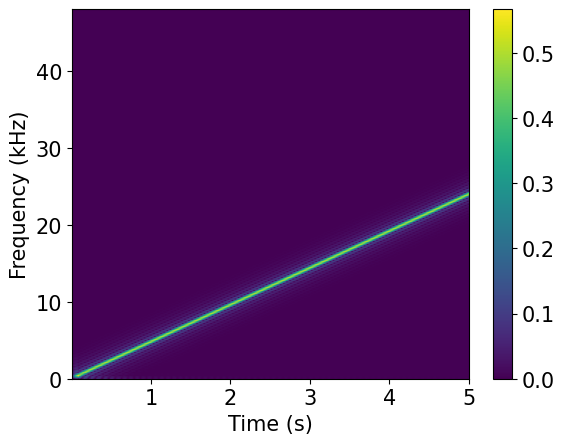

In [52]:

# Simulate LFM
fs=96000    # sampling frequency (Hz)
t2=5        # LFM duration (s)

f1=0        # LFM start frequency (Hz)
f2=24000    # LFM stop frequency (Hz)
# generate time vector
tt=np.arange(0,t2,1/fs)
# generate modulation frequency
om=2*np.pi*(f1+(f2-f1)/2*tt/t2)
#
xx=np.sin(om*tt)
#
print(DT1*fs/1000, 'samples')
#
# prepare some more space than needed for signal
yy=np.zeros(len(tt)+2*96)
nd=np.shape(xx)[0]
ndh=nd//2
#
# for matched filter (here not used)
rep=np.flipud(xx)/np.sqrt((nd/2*np.sum(xx**2)))
#

yy[96:-96]+=xx
ty=np.arange(len(yy))/fs

nw=256
#
f,t,S1= sig.spectrogram(yy,fs=fs,nperseg=nw,noverlap=nw//2,nfft=nw*2,scaling='spectrum',mode='complex')
ext=[t[0],t[-1],f[0]/1000,f[-1]/1000]
print(S1.shape)
#
plt.imshow(np.abs(S1),origin='lower', aspect='auto',extent=ext)
plt.colorbar()
plt.xlabel('Time (s)')
plt.ylabel('Frequency (kHz)')
plt.show();


In [53]:
#delay signal according to array geometry
kk=np.arange(-10,10,1);
ss=np.zeros((len(yy),len(DT1)))
for ii in range(len(DT1)):
    ss[:,ii]=fftfilt(np.sinc(kk+DT1[ii]*fs/1000),yy)

nn=np.random.normal(scale=0.1, size=ss.shape)
ss +=nn


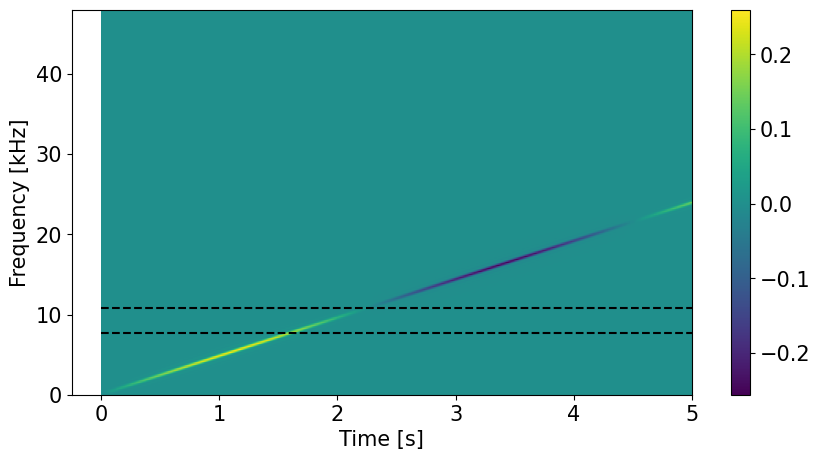

In [54]:
# process signal
nw=256
nover=nw/2
nfft=2*nw
n1=int(1+nfft//2)
n2=int((ss.shape[0]-nover)/nover)
nch=ss.shape[1]
Q=np.zeros((n1,n2,nch),dtype='complex')
for ii in range(nch):
    f,t,Q[:,:,ii]= sig.spectrogram(ss[:,ii],fs=fs,nperseg=nw,noverlap=nw//2,nfft=nw*2,scaling='spectrum',mode='complex')

# spectral intensity components
ns=np.shape(isel)[0]
C=np.zeros((n1,n2,ns))
for ii in range(ns):
    C[:,:,ii] = -np.imag(Q[:,:,isel[ii,0]]*np.conjugate(Q[:,:,isel[ii,1]]))

fig = plt.figure("figsize",[10,5])
plt.imshow(C[:,:,0],origin='lower', aspect='auto',extent=(t[0],t[-1],f[0]/1000,f[-1]/1000))
plt.hlines(np.min(0.75/L),0,5,colors='k',linestyles='--')
plt.hlines(np.max(0.75/L),0,5,colors='k',linestyles='--')

plt.xlabel('Time [s]')
plt.ylabel('Frequency [kHz]')
plt.colorbar()
plt.show()


(257, 3750, 15) (3, 15)
(257, 3750, 3)


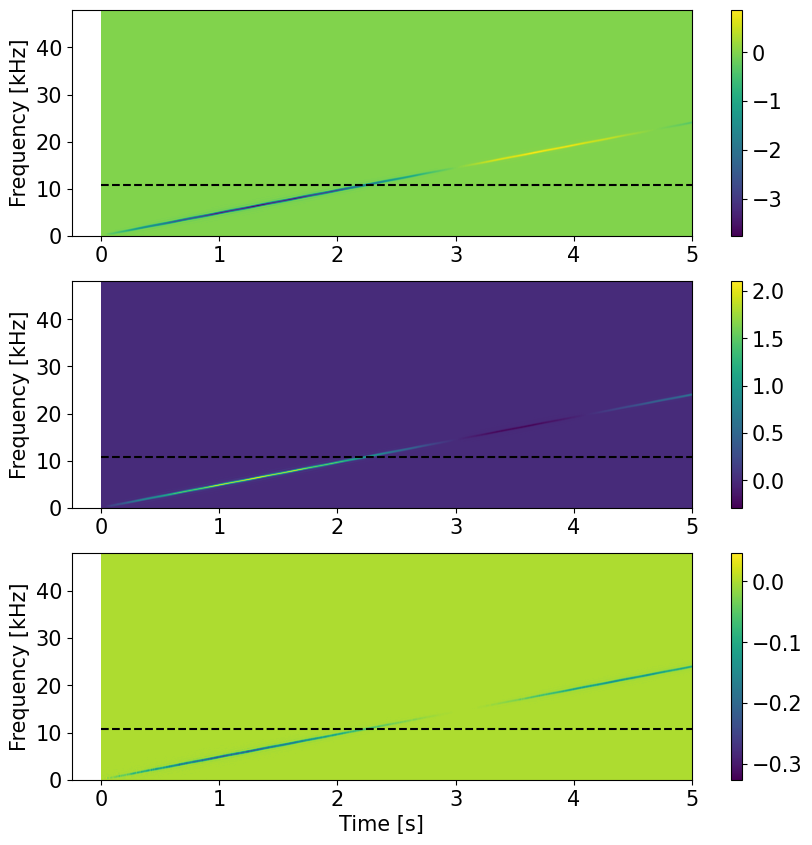

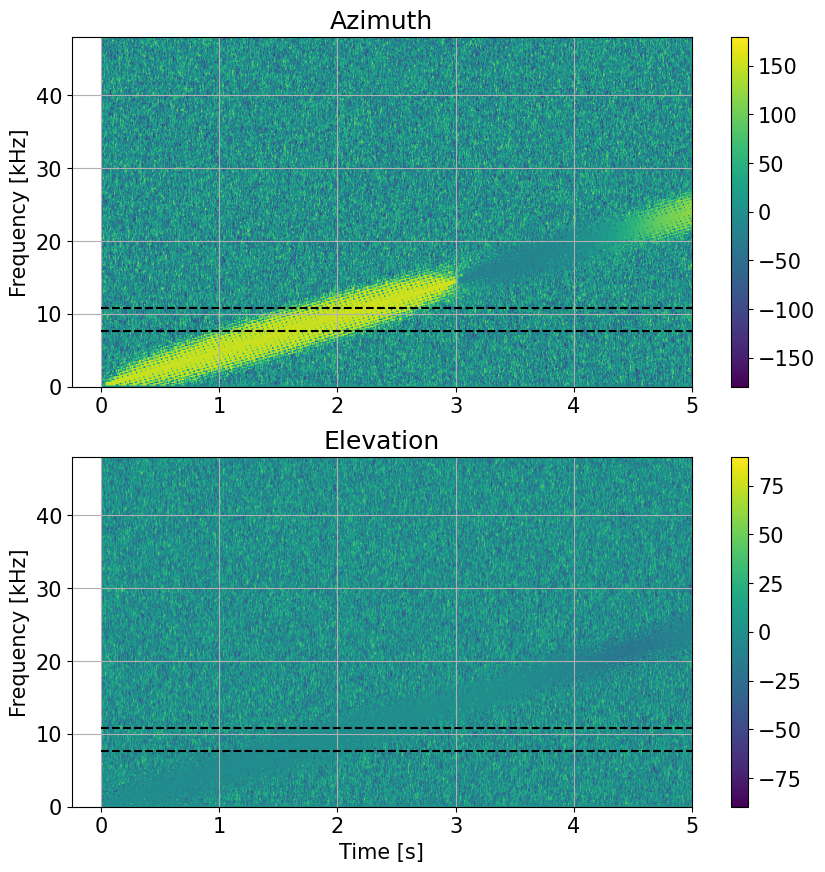

In [55]:
# spectral intensity vector
print(C.shape,DI.shape)
I=C@DI.T
print(I.shape)

fig = plt.figure("figsize",[10,10])
plt.subplot(311)
plt.imshow(I[:,:,0],origin='lower', aspect='auto',extent=(t[0],t[-1],f[0]/1000,f[-1]/1000))
plt.hlines(np.max(0.75/L),0,5,colors='k',linestyles='--')
plt.colorbar()
plt.ylabel('Frequency [kHz]')
plt.subplot(312)
plt.imshow(I[:,:,1],origin='lower', aspect='auto',extent=(t[0],t[-1],f[0]/1000,f[-1]/1000))
plt.hlines(np.max(0.75/L),0,5,colors='k',linestyles='--')
plt.colorbar()
plt.ylabel('Frequency [kHz]')
plt.subplot(313)
plt.imshow(I[:,:,2],origin='lower', aspect='auto',extent=(t[0],t[-1],f[0]/1000,f[-1]/1000))
plt.hlines(np.max(0.75/L),0,5,colors='k',linestyles='--')
plt.colorbar()

plt.xlabel('Time [s]')
plt.ylabel('Frequency [kHz]')
plt.show()

# angles
Azx=180/np.pi*np.arctan2(I[:,:,1],I[:,:,0])
Elx=180/np.pi*np.arctan2(I[:,:,2],np.sqrt(I[:,:,0]**2+I[:,:,1]**2))

fig = plt.figure("figsize",[10,10])
plt.subplot(211)
plt.imshow(Azx,origin='lower', aspect='auto',extent=(t[0],t[-1],f[0]/1000,f[-1]/1000))
plt.hlines(np.min(0.75/L),0,5,colors='k',linestyles='--')
plt.hlines(np.max(0.75/L),0,5,colors='k',linestyles='--')
plt.colorbar()
plt.grid(True)
plt.ylabel('Frequency [kHz]')
plt.title('Azimuth')

plt.subplot(212)
plt.imshow(Elx,origin='lower', aspect='auto',extent=(t[0],t[-1],f[0]/1000,f[-1]/1000))
plt.hlines(np.min(0.75/L),0,5,colors='k',linestyles='--')
plt.hlines(np.max(0.75/L),0,5,colors='k',linestyles='--')
plt.colorbar()

plt.grid(True)
plt.xlabel('Time [s]')
plt.ylabel('Frequency [kHz]')
plt.title('Elevation')
plt.show()


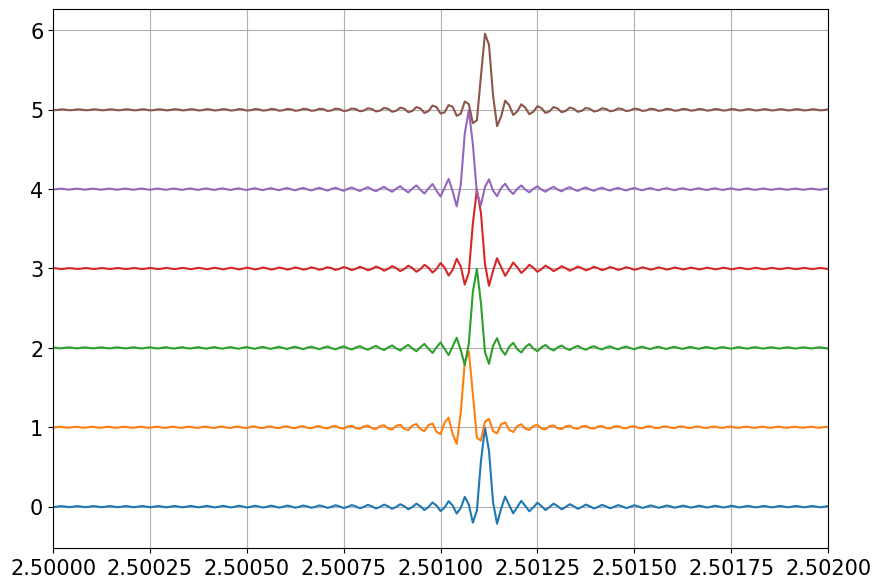

In [56]:
# LFM with matched filter

zz=0*ss
for ii in range(6):
    zz[:,ii]=fftfilt(rep,np.append(ss[:,ii], np.zeros((len(rep),1))))[len(rep)//2:-len(rep)//2]
plt.figure(figsize=(10,7))
plt.plot(ty,zz+np.ones((zz.shape[0],1))*range(6))
plt.xlim(2.5,2.502)
plt.grid(True)
plt.show()

(257, 7500)


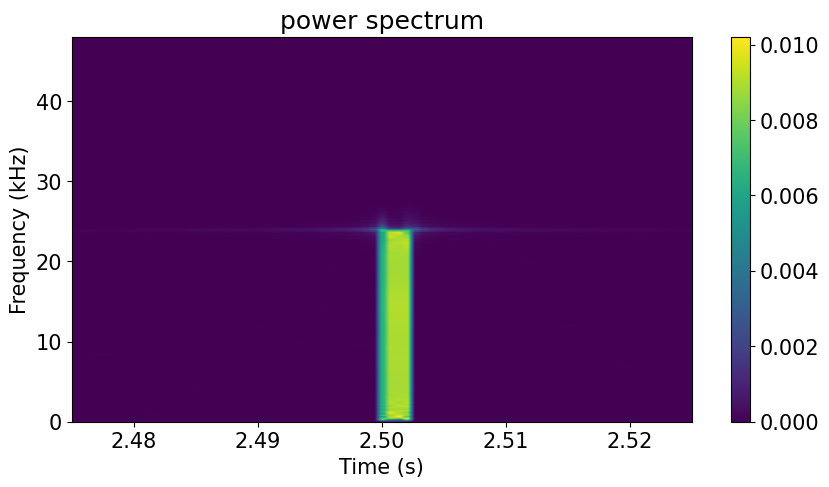

In [57]:
nover=int(nw//4*3)
f,t,S1= sig.spectrogram(zz[:,0],fs=fs,nperseg=nw,noverlap=nover,nfft=nw*2,scaling='spectrum',mode='complex')
ext=[t[0],t[-1],f[0]/1000,f[-1]/1000]
print(S1.shape)
#
xl=(2.475,2.525)

plt.figure(figsize=(10,5))
plt.imshow(np.abs(S1),origin='lower', aspect='auto',extent=ext)
plt.colorbar()
plt.xlim(xl)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (kHz)')
plt.title('power spectrum')
plt.show();


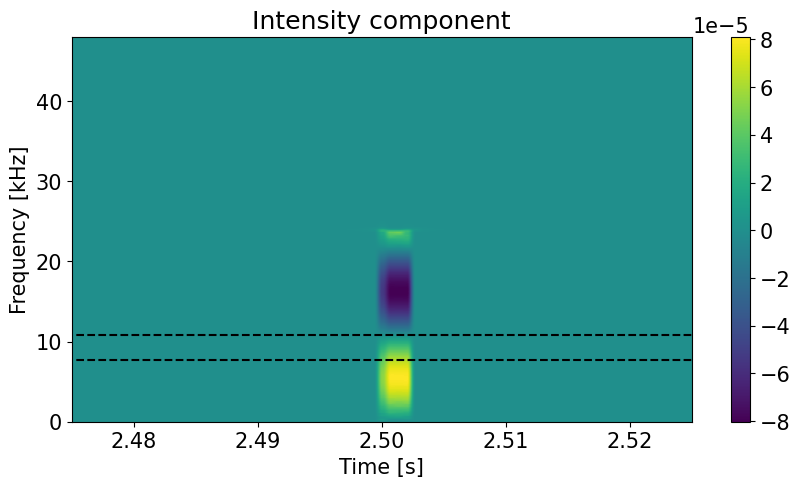

In [58]:
n1,n3=S1.shape
Q=np.zeros((n1,n3,6),dtype='complex')
for ii in range(6):
    f,t,Q[:,:,ii]= sig.spectrogram(zz[:,ii],fs=fs,nperseg=nw,noverlap=nover,nfft=nw*2,scaling='spectrum',mode='complex')

C=np.zeros((n1,n3,ns))
for ii in range(ns):
    C[:,:,ii] = -np.imag(Q[:,:,isel[ii,0]]*np.conjugate(Q[:,:,isel[ii,1]]))

fig = plt.figure("figsize",[10,5])
plt.imshow(C[:,:,0],origin='lower', aspect='auto',extent=(t[0],t[-1],f[0]/1000,f[-1]/1000))
plt.hlines(np.min(0.75/L),0,5,colors='k',linestyles='--')
plt.hlines(np.max(0.75/L),0,5,colors='k',linestyles='--')
plt.xlim(xl)
plt.xlabel('Time [s]')
plt.ylabel('Frequency [kHz]')
plt.colorbar()
plt.title('Intensity component')
plt.show()


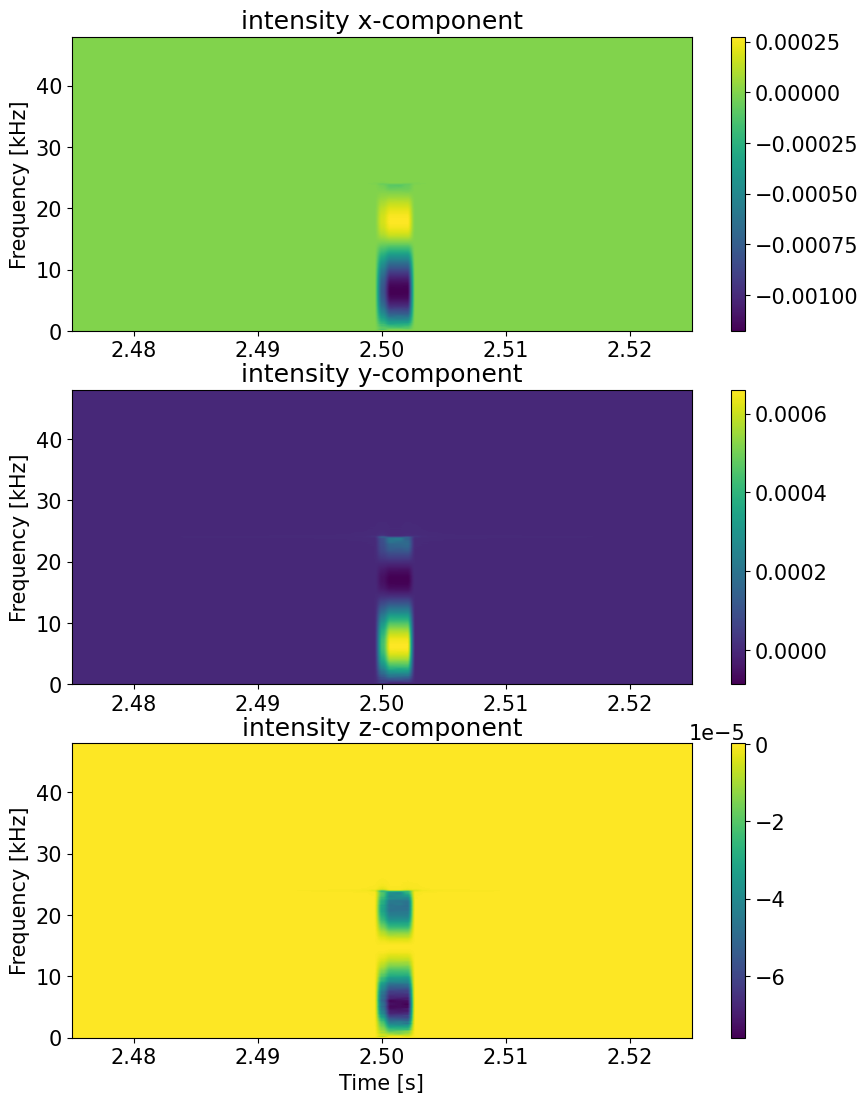

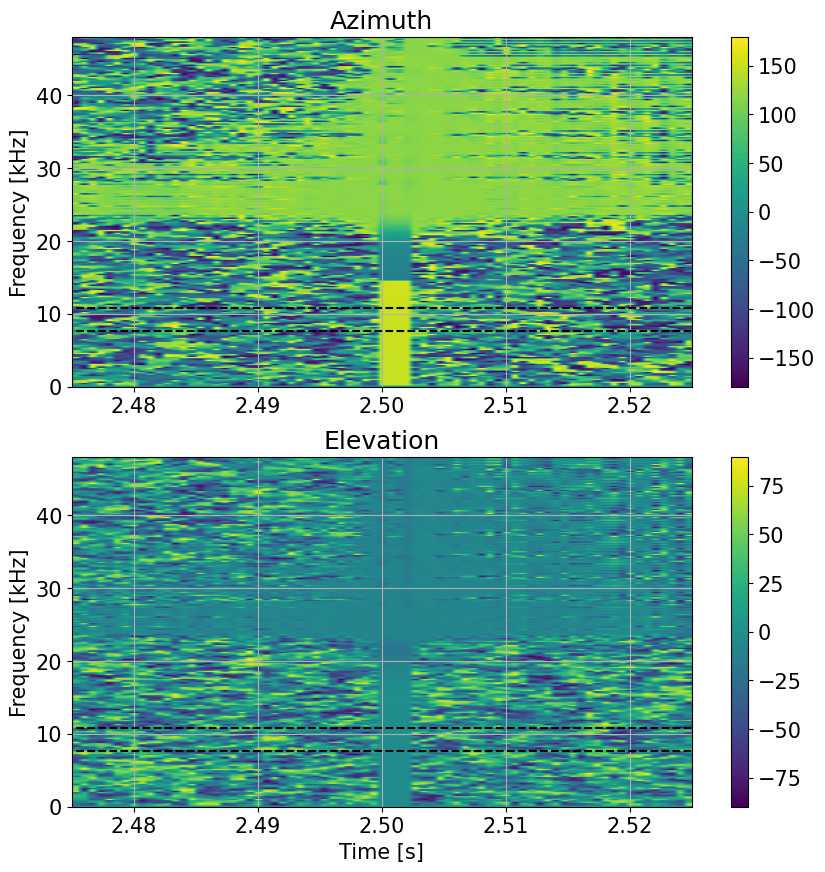

In [59]:
I=C@DI.T

fig = plt.figure("figsize",[10,13])
plt.subplot(311)
plt.imshow(I[:,:,0],origin='lower', aspect='auto',extent=(t[0],t[-1],f[0]/1000,f[-1]/1000))
plt.xlim(xl)
plt.colorbar()
plt.ylabel('Frequency [kHz]')
plt.title('intensity x-component')
plt.subplot(312)
plt.imshow(I[:,:,1],origin='lower', aspect='auto',extent=(t[0],t[-1],f[0]/1000,f[-1]/1000))
plt.xlim(xl)
plt.colorbar()
plt.ylabel('Frequency [kHz]')
plt.title('intensity y-component')
plt.subplot(313)
plt.imshow(I[:,:,2],origin='lower', aspect='auto',extent=(t[0],t[-1],f[0]/1000,f[-1]/1000))
plt.xlim(xl)
plt.colorbar()
plt.title('intensity z-component')

plt.xlabel('Time [s]')
plt.ylabel('Frequency [kHz]')
plt.show()

Azx=180/np.pi*np.arctan2(I[:,:,1],I[:,:,0])
Elx=180/np.pi*np.arctan2(I[:,:,2],np.sqrt(I[:,:,0]**2+I[:,:,1]**2))

fig = plt.figure("figsize",[10,10])
plt.subplot(211)
plt.imshow(Azx,origin='lower', aspect='auto',extent=(t[0],t[-1],f[0]/1000,f[-1]/1000))
plt.xlim(xl)
plt.hlines(np.min(0.75/L),0,5,colors='k',linestyles='--')
plt.hlines(np.max(0.75/L),0,5,colors='k',linestyles='--')
plt.colorbar()
plt.grid(True)
plt.ylabel('Frequency [kHz]')
plt.title('Azimuth')

plt.subplot(212)
plt.imshow(Elx,origin='lower', aspect='auto',extent=(t[0],t[-1],f[0]/1000,f[-1]/1000))
plt.xlim(xl)
plt.hlines(np.min(0.75/L),0,5,colors='k',linestyles='--')
plt.hlines(np.max(0.75/L),0,5,colors='k',linestyles='--')
plt.colorbar()

plt.grid(True)
plt.xlabel('Time [s]')
plt.ylabel('Frequency [kHz]')
plt.title('Elevation')
plt.show()


[240107 240103 240105 240105 240103 240107]
[[2.40107092e+05 9.98187402e-01]
 [2.40102702e+05 9.86533590e-01]
 [2.40104904e+05 9.98173127e-01]
 [2.40105096e+05 9.98036954e-01]
 [2.40102907e+05 9.97718672e-01]
 [2.40107295e+05 9.86302315e-01]]


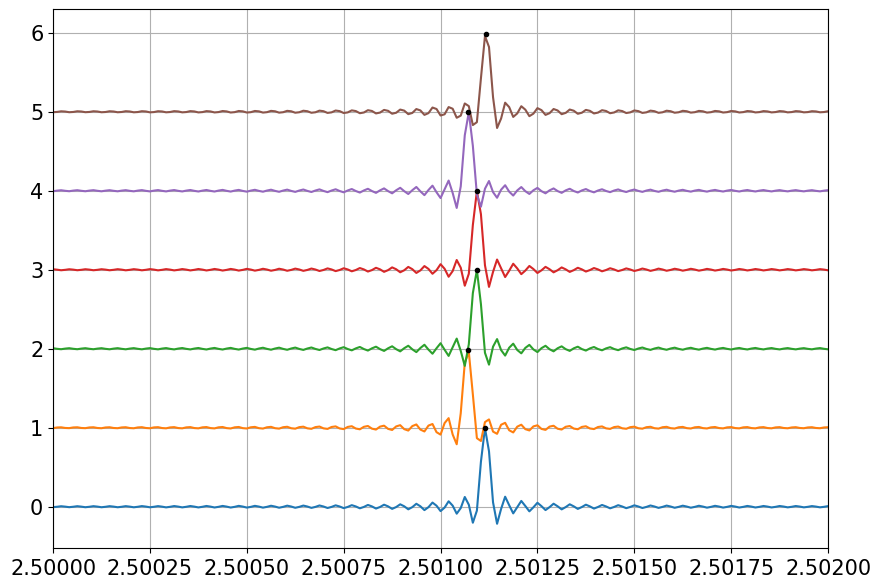

In [60]:
# time delay of arrival
def quadInt(uu,imx,nd1,nc):
    ux=np.zeros((nc,2))
    for ii in range(nc):
        uo=uu[imx[ii],ii]
        um=uu[imx[ii]-1,ii]
        up=uu[imx[ii]+1,ii]

        b=(up+um-2*uo)/2;

        xo=(um-up)/(4*b);
        yo=uo-b*xo**2;

        xo += imx[ii]-nd1/2;
        ux[ii,0]=xo
        ux[ii,1]=yo
    return ux

imx=np.argmax(zz,axis=0)
print(imx)
ux=quadInt(zz,imx,0,6)
print(ux)

plt.figure(figsize=(10,7))
plt.plot(ty,zz+np.ones((zz.shape[0],1))*range(6))
plt.plot(ux[:,0]/fs,ux[:,1]+np.arange(6),'k.')
plt.xlim(2.5,2.502)
plt.grid(True)
plt.show()

In [61]:
vv=ux[isel[:,0],0]-ux[isel[:,1],0]
print(vv)
J=vv@DI.T
print(J)

azx=180/np.pi*np.arctan2(J[1],J[0])
elx=180/np.pi*np.arctan2(J[2],np.sqrt(J[0]**2+J[1]**2))
print(azx,elx)

[ 4.3896845   2.18757564  1.99609991  4.18433927 -0.20324562 -2.20210886
 -2.39358459 -0.20534523 -4.59293012 -0.19147573  1.99676363 -2.39082126
  2.18823936 -2.19934553 -4.38758489]
[-54.80451827  31.76476095  -3.53592625]
149.90337047459263 -3.1949637188469238
